In [1]:
import time
from collections import deque, namedtuple
import gc
import tensorflow.keras.backend as K
import gym
from gym.wrappers import AtariPreprocessing, FrameStack
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # if GPU 1 is listed as device:0 in tf

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
from PIL import Image
import utils

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Add, Subtract, Average
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
os.makedirs("checkpoints",exist_ok=True)

c:\Users\amann\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\envs\registration.py:423: UserWarning: WARN: Custom namespace `ALE` is being overridden by namespace `ALE`. If you are developing a plugin you shouldn't specify a namespace in `register` calls. The namespace is specified through the entry point package metadata.
  logger.warn(


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available: 1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12888000786911731023
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1722023936
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17641995277208017420
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 4GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
tf.random.set_seed(utils.SEED)

In [3]:
MEMORY_SIZE = 300000
GAMMA = 0.99
ALPHA = 0.00025
NUM_STEPS_FOR_UPDATE = 4

In [4]:
env = gym.make("BreakoutNoFrameskip-v4")
env = AtariPreprocessing(env, grayscale_obs=True, scale_obs=True, frame_skip=4)
env = FrameStack(env, num_stack=4)

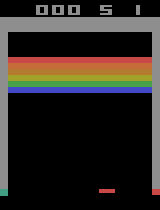

In [5]:
initial_state = env.reset()
Image.fromarray(env.render(mode='rgb_array'))

In [6]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print("State Shape:",state_size) 
print("Number of actions:",num_actions) 

State Shape: (4, 84, 84)
Number of actions: 4


In [7]:
action = 0
next_state, reward, done, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:",initial_state)
    print("Action:",action)
    print("Next State:",next_state)
    print("Reward Received:", reward)
    print("Episode Terminated:",done)
    print("Info:",info)

Initial State: <gym.wrappers.frame_stack.LazyFrames object at 0x0000028E93DC3B00>
Action: 0
Next State: <gym.wrappers.frame_stack.LazyFrames object at 0x0000028EA1FF8590>
Reward Received: 0.0
Episode Terminated: False
Info: {'lives': 5, 'episode_frame_number': 26, 'frame_number': 26}


In [8]:
def build_dueling_dqn(input_shape, num_actions):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, 8, strides=4, activation='relu')(inputs)
    x = Conv2D(64, 4, strides=2, activation='relu')(x)
    x = Conv2D(64, 3, strides=1, activation='relu')(x)
    x = Flatten()(x)

    # Shared dense layer
    x = Dense(512, activation='relu')(x)

    # Value Stream
    v = Dense(1)(x)  # output shape: (None, 1)

    # Advantage Stream
    a = Dense(num_actions)(x)  # output shape: (None, num_actions)

    # Combine V and A into Q-values using: Q(s,a) = V(s) + (A(s,a) - mean(A))
    def dueling_q_output(args):
        v, a = args
        return v + (a - tf.reduce_mean(a, axis=1, keepdims=True))

    q_values = Lambda(dueling_q_output)([v, a])

    model = Model(inputs=inputs, outputs=q_values)
    return model

input_shape = (84, 84, 4)
num_actions = env.action_space.n

q_network = build_dueling_dqn(input_shape, num_actions)
target_q_network = build_dueling_dqn(input_shape, num_actions)

optimizer = Adam(learning_rate=ALPHA)

c:\Users\amann\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)


In [9]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [10]:
@tf.function
def compute_loss(experiences, gamma, q_network, target_q_network):
    states, actions, rewards, next_states , done_vals = experiences

    states = tf.transpose(states, perm=[0,2,3,1])
    next_states = tf.transpose(next_states, perm=[0,2,3,1])

    next_q_values = q_network(next_states)
    best_next_actions = tf.argmax(next_q_values,axis=-1)

    target_q_values = target_q_network(next_states)
    max_qsa = tf.gather_nd(target_q_values,tf.stack([tf.range(tf.shape(target_q_values)[0], dtype=tf.int32),tf.cast(best_next_actions, tf.int32)], axis=1))

    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

    q_values = q_network(states)

    q_values = tf.gather_nd(q_values , tf.stack([tf.range(q_values.shape[0]), tf.cast(actions, tf.int32)], axis=1))

    loss = MSE(y_targets,q_values)

    return loss

In [11]:
@tf.function
def agent_learn(experiences, gamma):

    with tf.GradientTape() as tape:
        loss = compute_loss(experiences,gamma,q_network,target_q_network)

    gradients = tape.gradient(loss,q_network.trainable_variables)
    optimizer.apply_gradients(zip(gradients,q_network.trainable_variables))

    utils.update_target_network(q_network,target_q_network)

In [12]:
start = time.time()

num_p_av = 100
epsilon = 1.0
goal_reached = False

total_points_history = []
memory_buffer = deque(maxlen=MEMORY_SIZE)
losses = []
step_count = 0
total_frames = 0
save_interval = 250

max_episodes = 1001
max_timesteps_per_episode = 3000
target_reward = 300.0

target_q_network.set_weights(q_network.get_weights())

# === Resume from checkpoint ===
RESUME = True
RESUME_PATH = 'checkpoints/breakout_ep_1000.h5'
RESUME_EPISODE = 1000  # Start from episode 501

if RESUME:
    print(f"🔁 Resuming from checkpoint: {RESUME_PATH}")
    q_network.load_weights(RESUME_PATH)
    target_q_network.load_weights(RESUME_PATH)
    epsilon = 0.100   # match your log at episode 500
    total_frames = 1113064  # frames at episode 500
    start_episode = RESUME_EPISODE
else:
    epsilon = 1.0
    total_frames = 0
    start_episode = 0


for i in range(start_episode,max_episodes):
    state = env.reset()
    total_points = 0

    for t in range(max_timesteps_per_episode):
        step_count += 1
        total_frames += 4  # because frame_skip = 4

        if isinstance(state, gym.wrappers.frame_stack.LazyFrames):
          state = np.asarray(state)  # zero-copy if already concrete
        state_input = state.transpose(1, 2, 0)[np.newaxis, ...]

        q_values = q_network.predict(state_input, verbose=0)
        action = utils.get_action(q_values, epsilon, num_actions)

        next_state, reward, done, info = env.step(action)
        reward = np.clip(reward, -1, 1)

        if isinstance(next_state, gym.wrappers.frame_stack.LazyFrames):
            next_state = np.asarray(next_state) 
        memory_buffer.append(experience(state, action, reward, next_state, done))

        if utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer):
            experiences = utils.get_experiences(memory_buffer)
            loss = compute_loss(experiences, GAMMA, q_network, target_q_network)
            losses.append(loss.numpy())
            agent_learn(experiences, GAMMA)

            del experiences
            del loss
            gc.collect()

        state = np.array(next_state)
        total_points += reward

        if done:
            break

    total_points_history.append(total_points)
    av_latest_points = np.mean(total_points_history[-num_p_av:])

    
    
    epsilon = utils.get_new_eps(epsilon)

    if i == 599:
        epsilon = 0.65
    elif i==899:
        epsilon = 0.3
    elif i == 1000:
        epsilon = 0.1

    gc.collect()
    K.clear_session()
    tf.keras.backend.clear_session()

    print(f"\rEp {i+1} | Avg(100): {av_latest_points:.2f} | Reward: {total_points:.2f} | "
          f"Eps: {epsilon:.3f} | Frames: {total_frames:,}", end="")

    if (i + 1) % num_p_av == 0:
        print(f"\n📊 Episode {i+1} | Avg Reward (last 100): {av_latest_points:.2f}")

    if (i + 1) % save_interval == 0:
        q_network.save(f'checkpoints/breakout_ep_{i+1}.h5')
        print(f"\n💾 Checkpoint saved at episode {i+1}")

    if av_latest_points >= target_reward:
        q_network.save('Breakout_solved_model.h5')
        print(f"\n✅ Environment solved in {i+1} episodes! Avg Reward: {av_latest_points:.2f}")
        break
q_network.save('Model.h5')
tot_time = time.time() - start
print(f"\n🕒 Total Training Time: {tot_time:.2f} s ({tot_time / 60:.2f} min)")

🔁 Resuming from checkpoint: checkpoints/breakout_ep_1000.h5
Ep 1001 | Avg(100): 14.00 | Reward: 14.00 | Eps: 0.100 | Frames: 1,115,420WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.

🕒 Total Training Time: 36.72 s (0.61 min)


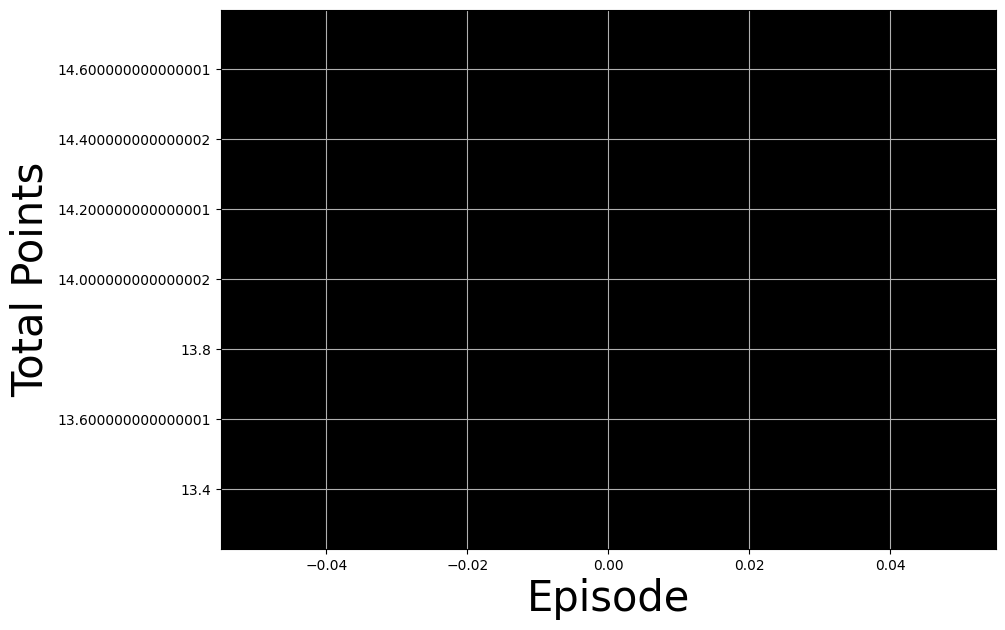

In [13]:
# Plot the point history
utils.plot_history(total_points_history)

In [14]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [15]:
filename = "./videos/breakout.mp4"

utils.create_video(filename, q_network)
utils.embed_mp4(filename)

Step:  136 | Action: 3 | Reward: 0.0 | Done: False
⚠️ Life lost! Forcing FIRE.
Step:  290 | Action: 0 | Reward: 0.0 | Done: False
⚠️ Life lost! Forcing FIRE.
Step:  425 | Action: 0 | Reward: 0.0 | Done: False
⚠️ Life lost! Forcing FIRE.
Step:  479 | Action: 0 | Reward: 0.0 | Done: False
⚠️ Life lost! Forcing FIRE.
Step:  595 | Action: 2 | Reward: 0.0 | Done: False
⚠️ Life lost! Forcing FIRE.
Step:  596 | Action: 3 | Reward: 0.0 | Done: True
✅ Video generation complete.
